# <font style="color:blue">Project 3: Object Detection</font>


#### Maximum Points: 100

<div>
    <table>
        <tr><td><h3>Sr. no.</h3></td> <td><h3>Section</h3></td> <td><h3>Points</h3></td> </tr>
        <tr><td><h3>1</h3></td> <td><h3>Plot Ground Truth Bounding Boxes</h3></td> <td><h3>20</h3></td> </tr>
        <tr><td><h3>2</h3></td> <td><h3>Training</h3></td> <td><h3>25</h3></td> </tr>
        <tr><td><h3>3</h3></td> <td><h3>Inference</h3></td> <td><h3>15</h3></td> </tr>
        <tr><td><h3>4</h3></td> <td><h3>COCO Detection Evaluation</h3></td> <td><h3>25</h3></td> </tr>
        <tr><td><h3>5</h3></td> <td><h3>Run Inference on a Video</h3></td> <td><h3>15</h3></td> </tr>
    </table>
</div>


# <font style="color:purple">Download the Dataset</font> 

**[Download the Vehicle registration plate](https://www.dropbox.com/s/k81ljpmzy3fgtx9/Dataset.zip?dl=1)**


Download the Vehicle Registration Plate dataset from [here](https://www.dropbox.com/s/k81ljpmzy3fgtx9/Dataset.zip?dl=1) and unzip it. 

We will have the following directory structure:

```
Dataset
├── train
│   └── Vehicle registration plate
│       └── Label
└── validation
    └── Vehicle registration plate
        └── Label
```

Unzipping the file will give you a directory `Dataset`. This directory has two folders: `train` and `validation`. Each train and validation folder has a `Vehicle registration plate`  folder with `.jpg` images and a folder `Labels` with `.txt` files. The `Label` folders have bounding box data for the images.


For example, the image, `Dataset/train/Vehicle registration plate/bf4689922cdfd532.jpg`, has the corresponding label file, `Dataset/train/Vehicle registration plate/Label/bf4689922cdfd532.txt`.

There are one or more lines in each `.txt` file. Each line represents a bounding box in the `class`, `xmin`, `ymin`, `xmax`, and `ymax` format. A representative label file is shown below.

```
Vehicle registration plate 385.28 445.15 618.24 514.225
Vehicle registration plate 839.68 266.066462 874.24 289.091462
```

This dataset has **5308** training and **386** validation dataset.



In [2]:
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-ilniww06
  Running command git clone -q https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-ilniww06


In [1]:
!conda install -c conda-forge opencv --y


Solving environment: done

## Package Plan ##

  environment location: /home/mhamdan/miniconda3

  added / updated specs:
    - opencv


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    _libgcc_mutex-0.1          |      conda_forge           3 KB  conda-forge
    _openmp_mutex-4.5          |           1_llvm           5 KB  conda-forge
    alsa-lib-1.2.3             |       h516909a_0         560 KB  conda-forge
    bzip2-1.0.8                |       h7f98852_4         484 KB  conda-forge
    c-ares-1.18.1              |       h7f98852_0         113 KB  conda-forge
    ca-certificates-2021.10.8  |       ha878542_0         139 KB  conda-forge
    cairo-1.16.0               |    h6cf1ce9_1008         1.5 MB  conda-forge
    certifi-2021.10.8          |   py38h578d9bd_1         145 KB  conda-forge
    cffi-1.15.0                |   py38h3931269_0         226 KB  conda-forge
    conda-4.11.0 

In [3]:

import os
import math
import random

import cv2
import detectron2
import detectron2.checkpoint
import detectron2.config
import detectron2.data
import detectron2.data.detection_utils as utils
import detectron2.evaluation
import detectron2.model_zoo
import detectron2.solver
import matplotlib.pyplot as plt
import numpy as np
import skimage.io
import torch
from detectron2.data import transforms as T
from IPython.utils import io
from PIL import Image
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm


class classproperty(property):
    def __get__(self, cls, owner):
        return classmethod(self.fget).__get__(None, owner)()

    
# ToDo: Investigate the warning below.

In [4]:
!pip install tensorboard

## <font style="color:orange">Vehicle Registration Plate Datastore</font>

To use custom datasets with Detectron2 for standard tasks, e.g., instance detection, instance/semantic/panoptic segmentation, keypoint detection, the dataset must be converted to Detectron2's [standard representation](https://detectron2.readthedocs.io/en/latest/tutorials/datasets.html#standard-dataset-dicts). The `Datastore` class follows the [singleton design pattern](https://www.tutorialspoint.com/python_design_patterns/python_design_patterns_singleton.htm). It loads this project's custom dataset into `list[dict]`. It also provides a method to fetch 1) specific image dicts via a list of image identifiers, or 2) a subset of image dicts via a percentage in the range of (0., 1.].

In [5]:
class Datastore(object):
    __instance = None
    __data_dir = "./dataset"
    
    @classproperty
    def instance(cls):
        if Datastore.__instance == None:
            Datastore()
        return Datastore.__instance

    @classproperty
    def data_dir(cls):
        return __data_dir

    def __init__(self):
        if Datastore.__instance != None:
            raise Exception("Datastore is a singleton. Use the Datastore.get_instance() method.")
        else:
            Datastore.__instance = self
            data_dir = Datastore.__data_dir
            self.__data_dir = Datastore.__data_dir
            self.__train_dir = os.path.join(data_dir, "train")
            self.__train_image_dir = os.path.join(data_dir, "train", "Vehicle registration plate")
            self.__train_label_dir = os.path.join(data_dir, "train", "Vehicle registration plate", "Label")
            self.__valid_dir = os.path.join(data_dir, "validation")
            self.__valid_image_dir = os.path.join(data_dir, "validation", "Vehicle registration plate")
            self.__valid_label_dir = os.path.join(data_dir, "validation", "Vehicle registration plate", "Label")
            if not self.__is_data_set_valid():
                raise IOError(f"'{data_dir}' is not a valid Vehicle Registration Plate dataset.")
            self._train_images = self.__process_data(self.__train_image_dir, self.__train_label_dir)
            self._valid_images = self.__process_data(self.__valid_image_dir, self.__valid_label_dir)

    def __is_data_set_valid(self):
        paths_and_counts = [
            (self.__data_dir, 2),
            (self.__train_dir, 1),
            (self.__train_image_dir, 5309),
            (self.__train_label_dir, 5308),
            (self.__valid_dir, 1),
            (self.__valid_image_dir, 387),
            (self.__valid_label_dir, 386)
        ]
       
        for path, count in paths_and_counts:
            if not os.path.isdir(path) or len(os.listdir(path)) != count:
                return False

        return True

    def __process_annotations(self, ann_path):
        boxes = []
        f = open(ann_path, 'r')
        for line in f.readlines():
            tokens = line.split(' ')
            xmin = float(tokens[3])
            ymin = float(tokens[4])
            xmax = float(tokens[5])
            ymax = float(tokens[6])
            assert xmax > xmin
            assert ymax > ymin
            boxes.append({
                "bbox": [xmin, ymin, xmax, ymax],
                "bbox_mode": detectron2.structures.BoxMode.XYXY_ABS,
                "category_id": 0,
                "iscrowd": 0
            })
        return boxes
        
    def __process_data(self, image_dir, label_dir):
        images = []
        for idx, img_name in enumerate(os.listdir(image_dir)):
            image_path = os.path.join(image_dir, img_name)
            label_path = os.path.join(label_dir, os.path.splitext(img_name)[0] + ".txt")           
            if os.path.isfile(image_path):
                img = Image.open(image_path)
                size = img.size
                img.close()
                del img
                images.append({
                    "file_name": image_path,
                    "image_id": idx,
                    "height": size[1],
                    "width": size[0],
                    "annotations": self.__process_annotations(label_path)
                })               
        return images
        
    def get_train_image_dict_list(self, ids=None, subset_size=None):
        return Datastore.__get_image_dict_list(self._train_images, ids, subset_size)

    def get_valid_image_dict_list(self, ids=None, subset_size=None):
        return Datastore.__get_image_dict_list(self._valid_images, ids, subset_size)
    
    @classmethod
    def __get_image_dict_list(cls, images, ids, subset_size):
        if ids is not None:
            return [images[id] for id in ids]
        
        if subset_size is not None:
            subset_size = float(subset_size)
            if subset_size <= 0. or subset_size > 1.:
                raise ValueError("subset_size must be a float whose value is in (0., 1.]")
            return cls.__create_subset(images, subset_size)
        
        return images
        
    @classmethod
    def __create_subset(cls, images, subset_size):
        indices = range(len(images))
        _, indices = np.unique([int(idx * subset_size) for idx in indices], return_index=True)
        return [images[idx] for idx in indices]

## <font style="color:orange">Vehicle Registration Plate Dataset Registration</font>

Custom datasets must also be registered with Detectron2 by implementing a function that returns the items in your dataset and then "telling" Detectron2 about this function (see [Register a Dataset](https://detectron2.readthedocs.io/en/latest/tutorials/datasets.html#register-a-dataset)). In addition, datasets may have associated metadata (see ["Metadata" for Datasets](https://detectron2.readthedocs.io/en/latest/tutorials/datasets.html#metadata-for-datasets)). The `Datasets` class registers the following datasets with "thing_classes", "thing_colors", and "dataset_size" metadata.

* Training Dataset
* Validation Dataset
* Training Subset
* Validation Subset

Note: `Datasets` is not instantiable. Call its `detectron2_registration()` class method to register the Vehicle Registration Plate datasets.

In [6]:
class Datasets(object):
    __registered = False
    __thing_classes = None
    __thing_colors = None
    __train_dataset_name = None
    __valid_dataset_name = None
    __train_dataset_subset_name = None
    __valid_dataset_subset_name = None
    __train_dataset_size = None
    __valid_dataset_size = None
    __train_dataset_subset_size = None
    __valid_dataset_subset_size = None
    __train_dataset_metadata = None
    __valid_dataset_metadata = None
    __train_dataset_subset_metadata = None
    __valid_dataset_subset_metadata = None

    @classproperty
    def thing_classes(cls):
        return Datasets.__thing_classes

    @classproperty
    def thing_colors(cls):
        return Datasets.__thing_colors

    @classproperty
    def train_dataset_name(cls):
        return Datasets.__train_dataset_name

    @classproperty
    def valid_dataset_name(cls):
        return Datasets.__valid_dataset_name

    @classproperty
    def train_dataset_subset_name(cls):
        return Datasets.__train_dataset_subset_name

    @classproperty
    def valid_dataset_subset_name(cls):
        return Datasets.__valid_dataset_subset_name

    @classproperty
    def train_dataset_size(cls):
        return Datasets.__train_dataset_size

    @classproperty
    def valid_dataset_size(cls):
        return Datasets.__valid_dataset_size

    @classproperty
    def train_dataset_subset_size(cls):
        return Datasets.__train_dataset_subset_size

    @classproperty
    def valid_dataset_subset_size(cls):
        return Datasets.__valid_dataset_subset_size

    @classproperty
    def train_dataset_metadata(cls):
        return Datasets.__train_dataset_metadata

    @classproperty
    def valid_dataset_metadata(cls):
        return Datasets.__valid_dataset_metadata

    @classproperty
    def train_dataset_subset_metadata(cls):
        return Datasets.__train_dataset_subset_metadata

    @classproperty
    def valid_dataset_subset_metadata(cls):
        return Datasets.__valid_dataset_subset_metadata
   
    def __init__(self):
        raise Exception("Datasets is not instantiable. Call Datasets.detectron2_registration().")
        
    @classmethod
    def __register_dataset(cls, name, func, size):
        detectron2.data.DatasetCatalog.register(name=name, func=func)
        metadata = detectron2.data.MetadataCatalog.get(name)
        metadata.thing_classes = Datasets.__thing_classes
        metadata.thing_colors = Datasets.__thing_colors
        metadata.dataset_size = size
        return metadata

    @classmethod
    def detectron2_registration(cls):
        if not Datasets.__registered:
            print("Registering datasets ...")
            Datasets.__registered = True
            Datasets.__thing_classes = ["lic. plate"]
            Datasets.__thing_colors = [(255, 140, 0)]

            train_dataset_func = lambda: Datastore.instance.get_train_image_dict_list()
            Datasets.__train_dataset_size = len(train_dataset_func())
            Datasets.__train_dataset_name = "vehicle_registration_plate/train/all"
            Datasets.__train_dataset_metadata = cls.__register_dataset(
                name = Datasets.__train_dataset_name,
                func = train_dataset_func,
                size = Datasets.__train_dataset_size
            )

            valid_dataset_func = lambda: Datastore.instance.get_valid_image_dict_list()
            Datasets.__valid_dataset_size = len(valid_dataset_func())
            Datasets.__valid_dataset_name = "vehicle_registration_plate/valid/all"
            Datasets.__valid_dataset_metadata = cls.__register_dataset(
                name = Datasets.__valid_dataset_name,
                func = valid_dataset_func,
                size = Datasets.__valid_dataset_size
            )

            train_dataset_subset_func = lambda: Datastore.instance.get_train_image_dict_list(subset_size=0.05)
            Datasets.__train_dataset_subset_size = len(train_dataset_subset_func())
            Datasets.__train_dataset_subset_name = "vehicle_registration_plate/train/subset"
            Datasets.__train_dataset_subset_metadata = cls.__register_dataset(
                name = Datasets.__train_dataset_subset_name,
                func = train_dataset_subset_func,
                size = Datasets.__train_dataset_subset_size
            )

            valid_dataset_subset_func = lambda: Datastore.instance.get_valid_image_dict_list(subset_size=0.05)
            Datasets.__valid_dataset_subset_size = len(valid_dataset_subset_func())
            Datasets.__valid_dataset_subset_name = "vehicle_registration_plate/valid/subset"
            Datasets.__valid_dataset_subset_metadata = cls.__register_dataset(
                name = Datasets.__valid_dataset_subset_name,
                func = valid_dataset_subset_func,
                size = Datasets.__valid_dataset_subset_size
            )
        



In [7]:
Datasets.detectron2_registration()

Registering datasets ...


## <font style="color:orange">Dataset Analysis</font>

It is useful to understand the dataset's image dimensions and aspect ratios when creating transforms and data loader collaters. The `analyze_image_dims()` function displays width, height, and aspect ratio histograms.

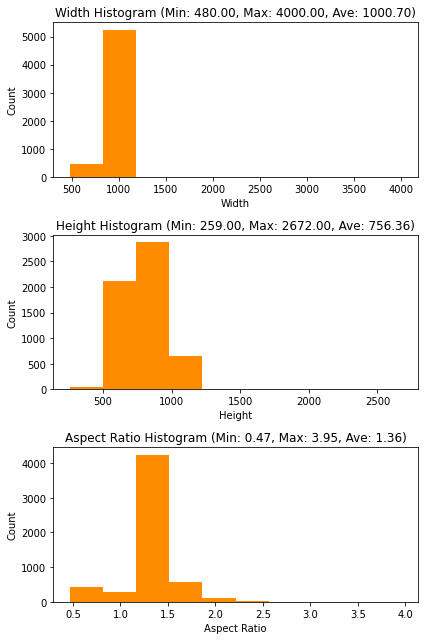

In [8]:
def analyze_image_dims():
    datastore = Datastore.instance
    
    # create list of training and validation samples
    images = []
    images.extend(datastore.get_train_image_dict_list())
    images.extend(datastore.get_valid_image_dict_list())

    def get_image_dims(image):
        width = image["width"]
        height = image["height"]
        return (width, height, float(width)/height)    

    image_dims = tuple(zip(*[get_image_dims(image) for image in images]))
    
    def plot_histogram(ax, xlabel, data):
        min = np.min(data)
        max = np.max(data)
        ave = np.mean(data)
        title = f"{xlabel} Histogram (Min: {min:.2f}, Max: {max:.2f}, Ave: {ave:.2f})"
        ax.hist(data, facecolor=(1., 0.549, 0))
        ax.set_xlabel(xlabel)
        ax.set_ylabel("Count")
        ax.set_title(title)

    fig, axs = plt.subplots(3, 1)
    fig.set_figwidth(6)
    fig.set_figheight(9)

    xlabels = ("Width", "Height", "Aspect Ratio")
    for ax, xlabel, data in zip(axs, xlabels, image_dims):
        plot_histogram(ax, xlabel, data)

    fig.tight_layout()
    plt.show()
    
    del images
    del image_dims


analyze_image_dims()

#  <font style="color:green">1. Plot Ground Truth Bounding Boxes [20 Points]</font> 

**You have to show three images from validation data with the bounding boxes.**

The plotted images should be similar to the following:

<img src='https://www.learnopencv.com/wp-content/uploads/2020/04/c3-w10-g1.png'>



<img src='https://www.learnopencv.com/wp-content/uploads/2020/04/c3-w10-g2.png'>



<img src='https://www.learnopencv.com/wp-content/uploads/2020/04/c3-w10-g3.png'>



## <font style="color:orange">Custom Annotator</font>

The Detectron2 has a robust [annotation and visualization](https://detectron2.readthedocs.io/en/latest/modules/utils.html#module-detectron2.utils.visualizer)  module. However, to learn how to annotate images in Python I wrote a custom `Annotator` class. This class draws labeled "ground truth" and "predicted" bounding boxes. Of note is this annotator's ability to scale its annotations according to bounding box sizes.

In [9]:
class Annotator(object):
    _min_pad = 3.
    _max_pad = 8.
    _min_scale = 0.333
    _max_scale = 1.
    _min_thick = 1.
    _max_thick = 5.
    _min_box_diag = 40.
    _max_box_diag = 200.

    @classmethod
    def _annotate_image(cls, img_bgr, bboxes, scores=None, color=(255, 140, 0)):
        white = (255, 255, 255)
        for idx, bbox in enumerate(bboxes):
            xminb, yminb, xmaxb, ymaxb = bbox
            xminb = int(xminb + 0.5)
            yminb = int(yminb + 0.5)
            xmaxb = int(xmaxb + 0.5)
            ymaxb = int(ymaxb + 0.5)
            scale, thick, pad = cls._compute_scaling_factors(xminb, yminb, xmaxb, ymaxb)
            cv2.rectangle(img_bgr, (xminb, yminb), (xmaxb, ymaxb), color, thick)

            text = "lic. plate"
            if scores is not None:
                text = format(scores[idx], ".0%")
            text_size, _ = cv2.getTextSize(text, cv2.FONT_HERSHEY_DUPLEX, scale, 1)

            xmint = xminb
            ymint = yminb - text_size[1] - pad
            xmaxt = xminb + text_size[0] + pad
            ymaxt = yminb
            xtext = xmint + int(pad / 2)
            ytext = ymint + text_size[1] + int(pad / 2)
            cv2.rectangle(img_bgr, (xmint, ymint), (xmaxt, ymaxt), color, thick)
            cv2.rectangle(img_bgr, (xmint, ymint), (xmaxt, ymaxt), color, -1)
            cv2.putText(img_bgr, text, (xtext, ytext), cv2.FONT_HERSHEY_DUPLEX, scale, white, 1)
        return img_bgr
    
    @classmethod
    def _compute_scaling_factors(cls, xmin, ymin, xmax, ymax):
        dx = (xmax - xmin)
        dy = (ymax - ymin)
        box_diag = math.sqrt(dx * dx + dy * dy)
        box_diag = max(min(box_diag, Annotator._max_box_diag), Annotator._min_box_diag)
        delta_box_diag = float(Annotator._max_box_diag - Annotator._min_box_diag)
        m_pad   = (Annotator._max_pad   - Annotator._min_pad)   / delta_box_diag
        m_scale = (Annotator._max_scale - Annotator._min_scale) / delta_box_diag
        m_thick = (Annotator._max_thick - Annotator._min_thick) / delta_box_diag
        delta_box_diag = float(box_diag - Annotator._min_box_diag)
        pad   = Annotator._min_pad   + m_pad   * delta_box_diag
        scale = Annotator._min_scale + m_scale * delta_box_diag
        thick = Annotator._min_thick + m_thick * delta_box_diag
        return scale, int(thick + 0.5), int(pad + 0.5)

    @classmethod
    def annotate_image_dict(cls, image_dict, color=(0, 140, 255)):
        img_bgr = cv2.imread(image_dict["file_name"])
        bboxes = [annotation["bbox"] for annotation in image_dict["annotations"]]
        return cls._annotate_image(img_bgr, bboxes, None, color)
    
    @classmethod
    def annotate_infer_dict(cls, infer_dict, img_bgr=None, color=((0, 140, 255), (0, 0, 255)), iou_thd=0.5):
        if img_bgr is None:
            img_bgr = cv2.imread(infer_dict["file_name"])
        pred_boxes = infer_dict["pred_boxes"]
        pred_scores = infer_dict["pred_scores"]
        if "gt_boxes" in infer_dict:
            missing_boxes = [gt_box for gt_box in infer_dict["gt_boxes"] 
                             if max([cls._compute_iou(gt_box, pred_box) for pred_box in pred_boxes]) < iou_thd]
            cls._annotate_image(img_bgr, missing_boxes, None, color[1])                
        return cls._annotate_image(img_bgr, pred_boxes, pred_scores, color[0])

    @classmethod
    def _compute_idx_max_iou(cls, bbox, bboxes):
        iou = [cls._compute_iou(bbox, bbox2) for bbox2 in bboxes]
        max_iou = max(iou)
        idx_iou = iou.index(max_iou)
        return idx_iou, max_iou
    
    @classmethod
    def _compute_iou(cls, bbox1, bbox2):
        xmin1, ymin1, xmax1, ymax1 = bbox1
        xmin2, ymin2, xmax2, ymax2 = bbox2

        xminI = max(xmin1, xmin2)
        yminI = max(ymin1, ymin2)
        xmaxI = min(xmax1, xmax2)
        ymaxI = min(ymax1, ymax2)
        
        if xmaxI < xminI or ymaxI < yminI:
            return 0.
        
        bbox1_area = (xmax1 - xmin1) * (ymax1 - ymin1)
        bbox2_area = (xmax2 - xmin2) * (ymax2 - ymin2)
        inter_area = (xmaxI - xminI) * (ymaxI - yminI)
        
        iou = inter_area / float(bbox1_area + bbox2_area - inter_area)
        assert iou >= 0.0
        assert iou <= 1.0
        return iou
    
    @classmethod
    def show_image(cls, img, is_rgb=False):
        plt.figure(figsize=(12,12))
        if is_rgb:
            plt.imshow(img)
        else:
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.show()
        



In [10]:
image_dict_list = Datastore.instance.get_valid_image_dict_list([4, 5, 6])

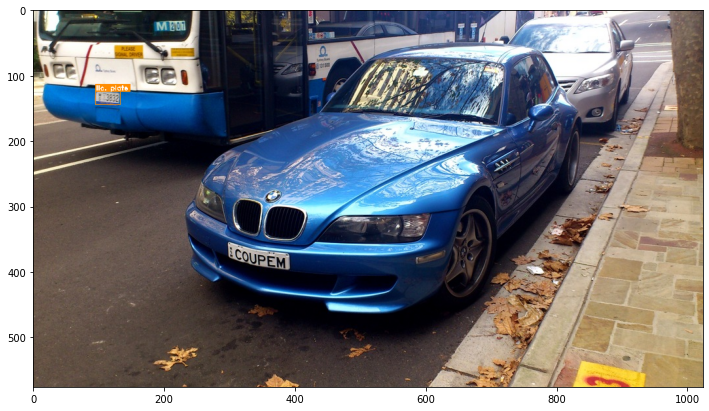

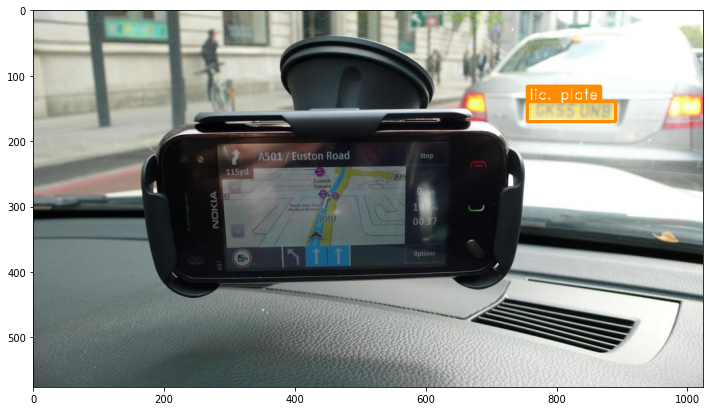

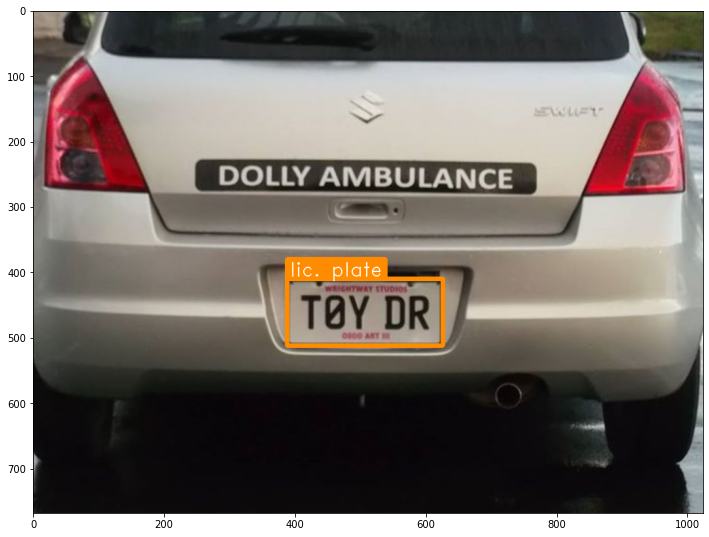

In [25]:
for i in range(3):
    Annotator.show_image(Annotator.annotate_image_dict(image_dict_list[i]))
    

#  <font style="color:green">2. Training [25 Points]</font> 

- **Write your training code in this section.**

- **You also have to share ([shared logs example](https://tensorboard.dev/experiment/JRtnsKbwTaq1ow6nPLPGeg)) the loss plot of your training using tensorboard.dev.** 

How to share TensorBoard logs using tensorboard.dev find [here](https://courses.opencv.org/courses/course-v1:OpenCV+OpenCV-106+2019_T1/courseware/b1c43ffe765246658e537109e188addb/d62572ec8bd344db9aeae81235ede618/4?activate_block_id=block-v1%3AOpenCV%2BOpenCV-106%2B2019_T1%2Btype%40vertical%2Bblock%40398b46ddcd5c465fa52cb4d572ba3229).

## <font style="color:orange">Inferencer and Trainer</font>

Detectron provides inference and training classes. Nevertheless, to better understand the nuisances of object detection, I implemented my own `Inferencer` and `Trainer` classes. The `Inferencer` class implements a method to perform a COCO evaluation of the model. The `Trainer` class is derived from the `Inferencer` so it has this same capability. 

In [12]:
class Inferencer(object):
    _output_dir = "./output"
    _output_name = "best_model"

    def __init__(self, cfg):
        Inferencer._setup_system(cfg)
        self._cfg = cfg
        self._model = detectron2.modeling.build_model(cfg)
        self._output_dir = self._create_output_dir(cfg)
        self._coco_evaluator = self._create_coco_evaluator(cfg)
        self._test_data_loader = detectron2.data.build_detection_test_loader(cfg, cfg.DATASETS.TEST[0])
        self._init_continued(cfg)

    def _init_continued(self, cfg):
        detectron2.checkpoint.DetectionCheckpointer(self._model).load(
            os.path.join(self._output_dir, Inferencer._output_name + ".pth")
        )

    def _create_output_dir(self, cfg):
        output_dir = os.path.join(Inferencer._output_dir, cfg.OUTPUT_DIR)
        os.makedirs(output_dir, exist_ok=True)
        return output_dir
    
    def _create_coco_evaluator(self, cfg):
        output_dir = os.path.join(Inferencer._output_dir, "CoCo")
        os.makedirs(output_dir, exist_ok=True)
        # suppress warning that config constructor is deprecated
        with io.capture_output():
            return detectron2.evaluation.COCOEvaluator(
                dataset_name = cfg.DATASETS.TEST[0],
                tasks = cfg,
                distributed = False,
                output_dir = output_dir
            )
        
    def evaluate_model(self):
        with io.capture_output() as captured:
            results = detectron2.evaluation.inference_on_dataset(
                self._model, 
                self._test_data_loader, 
                self._coco_evaluator
            )
        results_dict = results["bbox"]
        results_text = [line.strip() for line in captured.stdout.split('\n') if line.startswith("Average", 1)]
        return results_dict, results_text

    def inference_image_dict_list(self, image_dict_list, thd=0.4):
        mapper = detectron2.data.DatasetMapper(self._cfg, False)
        data_loader = detectron2.data.build_detection_test_loader(image_dict_list, mapper=mapper)
        return [self.inference_prepared_bgr_image(data_dict[0], image_dict["annotations"], thd) 
                for data_dict, image_dict in zip(data_loader, image_dict_list)]

    def inference_prepared_bgr_image(self, data_dict, annotations=None, thd=0.4):
        infer_dict = {}
        for key in ["image_id", "file_name", "width", "height"]:
            if key in data_dict:
                infer_dict[key] = data_dict[key]
        
        if annotations is not None:
            infer_dict["gt_boxes"] = [annotation["bbox"] for annotation in annotations]
            infer_dict["gt_classes"] = [annotation["category_id"] for annotation in annotations]
            
        self._model.eval()
        inference = self._model([data_dict])
        instances = inference[0]["instances"]
        instances = instances[instances.scores > thd]
        device = torch.device("cpu")
        
        infer_dict["pred_boxes"] = instances.pred_boxes.to(device).tensor.tolist()
        infer_dict["pred_scores"] = instances.scores.to(device).tolist()
        infer_dict["pred_classes"] = instances.pred_classes.to(device).tolist()

        return infer_dict
    
    def prepare_bgr_image(self, np_ndarray):
        width = np_ndarray.shape[1]
        height = np_ndarray.shape[0]
        aug_input = T.AugInput(np_ndarray)
        augmentations = T.AugmentationList(utils.build_augmentation(self._cfg, False))
        augmentations(aug_input)
        return {
            "width": width,
            "height": height,
            "image": torch.as_tensor(np.ascontiguousarray(aug_input.image.transpose(2, 0, 1)))
        }

    @classmethod
    def _setup_system(cls, cfg):
        seed = cfg.SEED
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        torch.set_printoptions(precision=10)
        if torch.cuda.is_available():
            torch.cuda.manual_seed_all(seed)
            torch.backends.cudnn_benchmark_enabled = False
            torch.backends.cudnn.deterministic = True
        
    
class Trainer(Inferencer):
    _runs_dir = "./runs"

    def __init__(self, cfg):
        super().__init__(cfg)
        self._train_data_loader, self._train_data_loader_len = Trainer._get_data_loader(cfg, cfg.DATASETS.TRAIN[0])
        self._valid_data_loader, self._valid_data_loader_len = Trainer._get_data_loader(cfg, cfg.DATASETS.TEST[0])

    def _init_continued(self, cfg):
        self._optimizer = detectron2.solver.build_optimizer(cfg, self._model)
        self._scheduler = detectron2.solver.build_lr_scheduler(cfg, self._optimizer)
        self._checkpointer = detectron2.checkpoint.DetectionCheckpointer(
            self._model, 
            self._output_dir, 
            optimizer = self._optimizer, 
            scheduler = self._scheduler
        )
        # suppress unwanted warnings that certain model weights are not loaded
        # because of differences in the number of classes
        with io.capture_output():  
            self._checkpointer.load(cfg.MODEL.WEIGHTS)

    @classmethod
    def _get_data_loader(cls, cfg, name):
        batch_size = cfg.SOLVER.IMS_PER_BATCH
        data_loader = detectron2.data.build_detection_train_loader(
            dataset = detectron2.data.DatasetCatalog.get(name),
            mapper = detectron2.data.DatasetMapper(cfg, True),
            total_batch_size = batch_size
        )
        dataset_len = detectron2.data.MetadataCatalog.get(name).dataset_size
        data_loader_len = int((dataset_len + batch_size - 1) / batch_size)
        return data_loader, data_loader_len
        
    def train(
        self, 
        exp_name, 
        num_epochs, 
        no_best_thd=None
    ):
        import torch.optim as optim
        import torch.optim.lr_scheduler as sched
        from detectron2.utils.events import EventStorage

        def create_tqdm_iter(desc, iterations, unit="batch"):
            return tqdm(
                range(iterations), 
                bar_format = "{l_bar}{bar}| {n_fmt:>4}/{total_fmt:4} [{elapsed}<{remaining}, {rate_fmt}{postfix}]", 
                desc = desc, 
                mininterval = 1., 
                unit = "batch"
            )
        
        def do_train_cycle(writer, train_data_iter, train_loss, epoch_num, iteration):
            self._model.train()
            cycle_pbar = create_tqdm_iter(f"Train {epoch_num:02d}", self._train_data_loader_len)
            for _ in cycle_pbar:
                iteration += 1
                data = next(train_data_iter)
                self._optimizer.zero_grad()
                loss_dict = self._model(data)
                class_loss = loss_dict["loss_cls"].mean()
                bregr_loss = loss_dict["loss_box_reg"].mean()
                (class_loss + bregr_loss).backward()
                ema = train_loss.add(float(class_loss), float(bregr_loss))
                loss_text = f"{{C:{ema[0]:.3f}, R:{ema[1]:.3f}, T:{ema[2]:.3f}}}"
                cycle_pbar.set_postfix(losses=loss_text)
                writer.add_scalar("param/lr", self._optimizer.param_groups[0]['lr'], iteration)
                writer.add_scalar("training/class_loss", ema[0], iteration)
                writer.add_scalar("training/regression_loss", ema[1], iteration)
                writer.add_scalar("training/total_loss", ema[2], iteration)
                self._optimizer.step()
                self._scheduler.step()                    
                del loss_dict
            cycle_pbar.close()
            return iteration
        
        def do_valid_cycle(writer, valid_data_iter, valid_loss, epoch_num, iteration):
            self._model.train()
            valid_loss.reset()
            cycle_pbar = create_tqdm_iter(f"Valid {epoch_num:02d}", self._valid_data_loader_len)
            for idx in cycle_pbar:
                data = next(valid_data_iter)
                with torch.no_grad():        
                    loss_dict = self._model(data)
                class_loss = loss_dict["loss_cls"].mean()
                bregr_loss = loss_dict["loss_box_reg"].mean()
                mean = valid_loss.add(float(class_loss), float(bregr_loss))
                loss_text = f"{{C:{mean[0]:.3f}, R:{mean[1]:.3f}, T:{mean[2]:.3f}}}"
                cycle_pbar.set_postfix(losses=loss_text)
                del loss_dict
            mean = valid_loss.mean
            writer.add_scalar("validation/class_loss", mean[0], iteration)
            writer.add_scalar("validation/regression_loss", mean[1], iteration)
            writer.add_scalar("validation/total_loss", mean[2], iteration)
            cycle_pbar.close()
                
        def do_model_evaluation(writer, iteration):
            cycle_pbar = create_tqdm_iter("CoCoEval", 1, "meval")
            for _ in cycle_pbar:
                eval_results, _ = self.evaluate_model()
                cycle_pbar.set_postfix(mAP=f"{eval_results['AP']:.3f}")
            cycle_pbar.close()
            for metric, value in eval_results.items():
                writer.add_scalar(f"test/{metric}", value, iteration)

        iteration = -1
        min_valid_loss = 1e10
        epochs_since_best = 0
        prev_best_iteration = -1
        train_loss = self.LossEMA()
        valid_loss = self.LossMean()
        train_data_iter = iter(self._train_data_loader)
        valid_data_iter = iter(self._valid_data_loader)
        writer = SummaryWriter(log_dir=os.path.join(Trainer._runs_dir, exp_name))
        with EventStorage(0):
            do_valid_cycle(writer, valid_data_iter, valid_loss, 0, 0)
            do_model_evaluation(writer, 0)
            for epoch_num in range(1, num_epochs + 1):
                iteration = do_train_cycle(writer, train_data_iter, train_loss, epoch_num, iteration)
                do_valid_cycle(writer, valid_data_iter, valid_loss, epoch_num, iteration)
                do_model_evaluation(writer, iteration)

                if min_valid_loss > valid_loss.mean[2]:
                    epochs_since_best = 0
                    min_valid_loss = valid_loss.mean[2]
                    self._checkpointer.save(Inferencer._output_name)
                else:
                    epochs_since_best += 1
                    if no_best_thd is not None and epochs_since_best >= no_best_thd:
                        break

                best_value = 0 if epochs_since_best > 0 else 1
                writer.add_scalar("param/best", best_value, prev_best_iteration + 1)
                writer.add_scalar("param/best", best_value, iteration)
                prev_best_iteration = iteration

        writer.close()
        self._model.eval()
    
    class EMA(object):
        def __init__(self, alpha=0.3):
            self.reset()
            self._alpha = alpha

        def reset(self):
            self._first = True
            self._ema = 0.
            
        @property
        def ema(self):
            return self._ema

        def add(self, x):
            self._ema = x if self._first else (1. - self._alpha) * self._ema + self._alpha * x
            self._first = False
            return self._ema

    class Mean(object):
        def __init__(self):
            self.reset()

        def reset(self):
            self._n = 0
            self._total = 0.
            
        @property
        def mean(self):
            return 0. if self._n == 0 else self._total / self._n

        def add(self, x):
            self._n += 1
            self._total += x
            return self.mean

    class LossEMA(object):
        def __init__(self):
            self._class_loss = Trainer.EMA()
            self._bregr_loss = Trainer.EMA()

        def reset(self):
            self._class_loss.reset()
            self._bregr_loss.reset()

        @property
        def ema(self):
            class_loss_ema = self._class_loss.ema
            bregr_loss_ema = self._bregr_loss.ema
            total_loss_ema = class_loss_ema + bregr_loss_ema
            return (class_loss_ema, bregr_loss_ema, total_loss_ema)

        def add(self, class_loss, bregr_loss):
            class_loss_ema = self._class_loss.add(class_loss)
            bregr_loss_ema = self._bregr_loss.add(bregr_loss)
            total_loss_ema = class_loss_ema + bregr_loss_ema
            return (class_loss_ema, bregr_loss_ema, total_loss_ema)
        
    class LossMean(object):
        def __init__(self):
            self._class_loss = Trainer.Mean()
            self._bregr_loss = Trainer.Mean()

        def reset(self):
            self._class_loss.reset()
            self._bregr_loss.reset()

        @property
        def mean(self):
            class_loss_mean = self._class_loss.mean
            bregr_loss_mean = self._bregr_loss.mean
            total_loss_mean = class_loss_mean + bregr_loss_mean
            return (class_loss_mean, bregr_loss_mean, total_loss_mean)

        def add(self, class_loss, bregr_loss):
            class_loss_mean = self._class_loss.add(class_loss)
            bregr_loss_mean = self._bregr_loss.add(bregr_loss)
            total_loss_mean = class_loss_mean + bregr_loss_mean
            return (class_loss_mean, bregr_loss_mean, total_loss_mean)

## <font style="color:orange">Detectron2 Configurations</font>

Detectron2 provides a key-value based configuration system that can be used to obtain standard, common behaviors as explained in the [Configs](https://detectron2.readthedocs.io/en/latest/tutorials/configs.html) documentation. I wrote helper functions to create configurations using either 1) all the images or a subset of them, and 2) no data augmentation or simple data augmentation. By simple data augmentation, I mean data augmentation that is available via configuration key-value pairs. More sophisacated data augmentation can be implemented (see [Data Augmentation](https://detectron2.readthedocs.io/en/latest/tutorials/augmentation.html#)).

In [13]:
def detectron2_cfg(
    exp_name,
    model_config, 
    num_epochs,
    batch_size,
    augment,
    subset
):
    if not subset:
        train_dataset_name = Datasets.train_dataset_name
        train_dataset_size = Datasets.train_dataset_size
        valid_dataset_name = Datasets.valid_dataset_name
        valid_dataset_size = Datasets.valid_dataset_size
    else:
        train_dataset_name = Datasets.train_dataset_subset_name
        train_dataset_size = Datasets.train_dataset_subset_size
        valid_dataset_name = Datasets.valid_dataset_subset_name
        valid_dataset_size = Datasets.valid_dataset_subset_size
    
    iters_per_epoch = int((train_dataset_size + batch_size - 1) / batch_size)

    cfg = detectron2.config.get_cfg()
    # suppress unwanted warnings about Detectron2 yaml loading
    with io.capture_output():  
        cfg.merge_from_file(detectron2.model_zoo.get_config_file(model_config))
    cfg.SEED = 42
    cfg.DATASETS.TRAIN = (train_dataset_name, )
    cfg.DATASETS.TEST = (valid_dataset_name, )
    cfg.DATALOADER.NUM_WORKERS = 12
    cfg.INPUT.RANDOM_FLIP = "none"
    cfg.MODEL.WEIGHTS = detectron2.model_zoo.get_checkpoint_url(model_config)
    cfg.MODEL.RETINANET.NUM_CLASSES = len(Datasets.thing_classes)
    cfg.OUTPUT_DIR = exp_name
    cfg.SOLVER.IMS_PER_BATCH = batch_size
    cfg.SOLVER.BASE_LR = 0.0001
    cfg.SOLVER.MAX_ITER = num_epochs * iters_per_epoch
    cfg.SOLVER.WARMUP_ITERS = 2 * iters_per_epoch
    cfg.TEST.EVAL_PERIOD = iters_per_epoch
    if augment:
        cfg.INPUT.CROP.ENABLED = True
        cfg.INPUT.CROP.SIZE = [0.9, 0.9]
        cfg.INPUT.CROP.TYPE = "relative_range"
        cfg.INPUT.MIN_SIZE_TRAIN = (640, 800)
        cfg.INPUT.MIN_SIZE_TRAIN_SAMPLING = "range"
        cfg.INPUT.RANDOM_FLIP = "horizontal"        
    return cfg
    
def retinanet50_cfg(exp_name, num_epochs, augment, subset):
    return detectron2_cfg(
        exp_name = exp_name,
        model_config = "COCO-Detection/retinanet_R_50_FPN_3x.yaml",
        num_epochs = num_epochs,
        batch_size = 8,
        augment = augment,
        subset = subset
    )
    
def retinanet101_cfg(exp_name, num_epochs, augment, subset):
    return detectron2_cfg(
        exp_name = exp_name,
        model_config = "COCO-Detection/retinanet_R_101_FPN_3x.yaml",
        num_epochs = num_epochs,
        batch_size = 6,
        augment = augment,
        subset = subset
    )
    
def fasterrcnnX101_cfg(exp_name, num_epochs, augment, subset):
    return detectron2_cfg(
        exp_name = exp_name,
        model_config = "COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml",
        num_epochs = num_epochs,
        batch_size = 3,
        augment = augment,
        subset = subset
    )
    
def create_config(exp_name, cfg_func, num_epochs=0, augment=False, subset=False):
    return cfg_func(exp_name, num_epochs, augment, subset)

## <font style="color:orange">Training Experiments and TensorBoard Logs</font>

This cell shows the output of a sample training experiment and contains a link to the TensorBoard logs generated by all experiments.

### <font style="color:orange">Training Experiments</font>

Training experiments are conducted via the `conduct_experiment` function. TQDM progress bars are used to display training progress. The following output is the first ten epochs of training the Retina-50 model without data augmentation on the entire dataset.

```
Valid 00: 100%|██████████|   49/49   [00:29<00:00,  1.67batch/s, losses={C:1.279, R:0.563, T:1.842}]
CoCoEval: 100%|██████████|    1/1    [00:20<00:00, 20.65s/batch, mAP=0.000]
Train 01: 100%|██████████|  664/664  [16:47<00:00,  1.52s/batch, losses={C:0.298, R:0.326, T:0.624}]
Valid 01: 100%|██████████|   49/49   [00:29<00:00,  1.68batch/s, losses={C:0.251, R:0.206, T:0.457}]
CoCoEval: 100%|██████████|    1/1    [00:21<00:00, 21.65s/batch, mAP=50.006]
Train 02: 100%|██████████|  664/664  [16:45<00:00,  1.51s/batch, losses={C:0.223, R:0.290, T:0.513}]
Valid 02: 100%|██████████|   49/49   [00:28<00:00,  1.70batch/s, losses={C:0.173, R:0.186, T:0.359}]
CoCoEval: 100%|██████████|    1/1    [00:21<00:00, 21.43s/batch, mAP=55.580]
Train 03: 100%|██████████|  664/664  [16:47<00:00,  1.52s/batch, losses={C:0.161, R:0.246, T:0.407}]
Valid 03: 100%|██████████|   49/49   [00:29<00:00,  1.69batch/s, losses={C:0.143, R:0.175, T:0.317}]
CoCoEval: 100%|██████████|    1/1    [00:21<00:00, 21.12s/batch, mAP=59.602]
Train 04: 100%|██████████|  664/664  [16:44<00:00,  1.51s/batch, losses={C:0.129, R:0.169, T:0.298}]
Valid 04: 100%|██████████|   49/49   [00:29<00:00,  1.68batch/s, losses={C:0.131, R:0.177, T:0.308}]
CoCoEval: 100%|██████████|    1/1    [00:20<00:00, 21.00s/batch, mAP=60.837]
Train 05: 100%|██████████|  664/664  [16:48<00:00,  1.52s/batch, losses={C:0.212, R:0.282, T:0.495}]
Valid 05: 100%|██████████|   49/49   [00:29<00:00,  1.66batch/s, losses={C:0.128, R:0.174, T:0.302}]
CoCoEval: 100%|██████████|    1/1    [00:21<00:00, 21.10s/batch, mAP=60.461]
Train 06: 100%|██████████|  664/664  [16:43<00:00,  1.51s/batch, losses={C:0.170, R:0.296, T:0.466}]
Valid 06: 100%|██████████|   49/49   [00:29<00:00,  1.69batch/s, losses={C:0.131, R:0.165, T:0.295}]
CoCoEval: 100%|██████████|    1/1    [00:21<00:00, 21.08s/batch, mAP=59.819]
Train 07: 100%|██████████|  664/664  [16:43<00:00,  1.51s/batch, losses={C:0.136, R:0.213, T:0.348}]
Valid 07: 100%|██████████|   49/49   [00:28<00:00,  1.70batch/s, losses={C:0.123, R:0.172, T:0.295}]
CoCoEval: 100%|██████████|    1/1    [00:21<00:00, 21.03s/batch, mAP=60.495]
Train 08: 100%|██████████|  664/664  [16:48<00:00,  1.52s/batch, losses={C:0.094, R:0.176, T:0.270}]
Valid 08: 100%|██████████|   49/49   [00:29<00:00,  1.69batch/s, losses={C:0.117, R:0.162, T:0.278}]
CoCoEval: 100%|██████████|    1/1    [00:20<00:00, 20.98s/batch, mAP=61.254]
Train 09: 100%|██████████|  664/664  [16:46<00:00,  1.52s/batch, losses={C:0.101, R:0.206, T:0.307}]
Valid 09: 100%|██████████|   49/49   [00:28<00:00,  1.69batch/s, losses={C:0.129, R:0.170, T:0.298}]
CoCoEval: 100%|██████████|    1/1    [00:21<00:00, 21.20s/batch, mAP=59.804]
Train 10: 100%|██████████|  664/664  [16:44<00:00,  1.51s/batch, losses={C:0.106, R:0.235, T:0.341}]
Valid 10: 100%|██████████|   49/49   [00:29<00:00,  1.65batch/s, losses={C:0.117, R:0.163, T:0.280}]
CoCoEval: 100%|██████████|    1/1    [00:20<00:00, 20.98s/batch, mAP=60.289]
```

### <font style="color:orange">TensorBoard Logs</font>

The TensorBoard logs



In [29]:
%tensorboard --logdir runs

UsageError: Line magic function `%tensorboard` not found.


In [14]:
def conduct_experiment(exp_name, cfg_func, num_epochs, no_best_thd, augment, subset):
    cfg = create_config(exp_name, cfg_func, num_epochs, augment, subset)
    trainer = Trainer(cfg)
    trainer.train(exp_name, num_epochs, no_best_thd)
    del trainer
    torch.cuda.empty_cache()
    return cfg


In [15]:
conduct_experiment("AAA-RetinaNet50-SUB",       retinanet50_cfg, 100, 10, False, True )


SOLVER.STEPS contains values larger than SOLVER.MAX_ITER. These values will be ignored.
2021-12-10 19:14:29.849630: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-10.0/lib64
2021-12-10 19:14:29.849659: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
Valid 00: 100%|█|    3/3    [00:02<00:00,  1.12batch/s, losses={C:1.892, R:0.591
CoCoEval: 100%|███████████████|    1/1    [00:02<00:00,  2.04s/batch, mAP=0.000]
Train 01: 100%|█|   34/34   [00:53<00:00,  1.59s/batch, losses={C:1.206, R:0.492
Valid 01: 100%|█|    3/3    [00:02<00:00,  1.16batch/s, losses={C:1.114, R:0.284
CoCoEval: 100%|███████████████|    1/1    [00:02<00:00,  2.15s/batch, mAP=0.000]
Train 02: 100%|█|   34/34   [00:42<00:00,  1.26s/batch, losses={C:0.809, R

CfgNode({'VERSION': 2, 'MODEL': CfgNode({'LOAD_PROPOSALS': False, 'MASK_ON': False, 'KEYPOINT_ON': False, 'DEVICE': 'cuda', 'META_ARCHITECTURE': 'RetinaNet', 'WEIGHTS': 'https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/retinanet_R_50_FPN_3x/190397829/model_final_5bd44e.pkl', 'PIXEL_MEAN': [103.53, 116.28, 123.675], 'PIXEL_STD': [1.0, 1.0, 1.0], 'BACKBONE': CfgNode({'NAME': 'build_retinanet_resnet_fpn_backbone', 'FREEZE_AT': 2}), 'FPN': CfgNode({'IN_FEATURES': ['res3', 'res4', 'res5'], 'OUT_CHANNELS': 256, 'NORM': '', 'FUSE_TYPE': 'sum'}), 'PROPOSAL_GENERATOR': CfgNode({'NAME': 'RPN', 'MIN_SIZE': 0}), 'ANCHOR_GENERATOR': CfgNode({'NAME': 'DefaultAnchorGenerator', 'SIZES': [[32, 40.31747359663594, 50.79683366298238], [64, 80.63494719327188, 101.59366732596476], [128, 161.26989438654377, 203.18733465192952], [256, 322.53978877308754, 406.37466930385904], [512, 645.0795775461751, 812.7493386077181]], 'ASPECT_RATIOS': [[0.5, 1.0, 2.0]], 'ANGLES': [[-90, 0, 90]], 'OFFSET': 0.0}), 'RP

In [16]:
conduct_experiment("AAB-RetinaNet50-ALL",       retinanet50_cfg, 100, 10, False, False)


SOLVER.STEPS contains values larger than SOLVER.MAX_ITER. These values will be ignored.
Valid 00: 100%|█|   49/49   [00:34<00:00,  1.40batch/s, losses={C:1.268, R:0.543
CoCoEval: 100%|███████████████|    1/1    [00:22<00:00, 22.46s/batch, mAP=0.000]
Train 01: 100%|█|  664/664  [14:28<00:00,  1.31s/batch, losses={C:0.319, R:0.246
Valid 01: 100%|█|   49/49   [00:34<00:00,  1.42batch/s, losses={C:0.242, R:0.196
CoCoEval: 100%|██████████████|    1/1    [00:23<00:00, 23.42s/batch, mAP=50.398]
Train 02: 100%|█|  664/664  [14:02<00:00,  1.27s/batch, losses={C:0.199, R:0.234
Valid 02: 100%|█|   49/49   [00:33<00:00,  1.46batch/s, losses={C:0.164, R:0.176
CoCoEval: 100%|██████████████|    1/1    [00:22<00:00, 22.86s/batch, mAP=56.952]
Train 03: 100%|█|  664/664  [13:59<00:00,  1.26s/batch, losses={C:0.154, R:0.261
Valid 03: 100%|█|   49/49   [00:33<00:00,  1.44batch/s, losses={C:0.142, R:0.168
CoCoEval: 100%|██████████████|    1/1    [00:22<00:00, 22.67s/batch, mAP=60.901]
Train 04: 100%|█|  66

CfgNode({'VERSION': 2, 'MODEL': CfgNode({'LOAD_PROPOSALS': False, 'MASK_ON': False, 'KEYPOINT_ON': False, 'DEVICE': 'cuda', 'META_ARCHITECTURE': 'RetinaNet', 'WEIGHTS': 'https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/retinanet_R_50_FPN_3x/190397829/model_final_5bd44e.pkl', 'PIXEL_MEAN': [103.53, 116.28, 123.675], 'PIXEL_STD': [1.0, 1.0, 1.0], 'BACKBONE': CfgNode({'NAME': 'build_retinanet_resnet_fpn_backbone', 'FREEZE_AT': 2}), 'FPN': CfgNode({'IN_FEATURES': ['res3', 'res4', 'res5'], 'OUT_CHANNELS': 256, 'NORM': '', 'FUSE_TYPE': 'sum'}), 'PROPOSAL_GENERATOR': CfgNode({'NAME': 'RPN', 'MIN_SIZE': 0}), 'ANCHOR_GENERATOR': CfgNode({'NAME': 'DefaultAnchorGenerator', 'SIZES': [[32, 40.31747359663594, 50.79683366298238], [64, 80.63494719327188, 101.59366732596476], [128, 161.26989438654377, 203.18733465192952], [256, 322.53978877308754, 406.37466930385904], [512, 645.0795775461751, 812.7493386077181]], 'ASPECT_RATIOS': [[0.5, 1.0, 2.0]], 'ANGLES': [[-90, 0, 90]], 'OFFSET': 0.0}), 'RP

In [16]:
conduct_experiment("AAC-RetinaNet50-AUG",       retinanet50_cfg, 100, 10, True,  False)


SOLVER.STEPS contains values larger than SOLVER.MAX_ITER. These values will be ignored.
2021-12-12 11:37:01.397849: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-10.0/lib64
2021-12-12 11:37:01.397881: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
CoCoEval: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████|    1/1    [00:22<00:00, 22.22s/batch, mAP=62.041]


CfgNode({'VERSION': 2, 'MODEL': CfgNode({'LOAD_PROPOSALS': False, 'MASK_ON': False, 'KEYPOINT_ON': False, 'DEVICE': 'cuda', 'META_ARCHITECTURE': 'RetinaNet', 'WEIGHTS': 'https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/retinanet_R_50_FPN_3x/190397829/model_final_5bd44e.pkl', 'PIXEL_MEAN': [103.53, 116.28, 123.675], 'PIXEL_STD': [1.0, 1.0, 1.0], 'BACKBONE': CfgNode({'NAME': 'build_retinanet_resnet_fpn_backbone', 'FREEZE_AT': 2}), 'FPN': CfgNode({'IN_FEATURES': ['res3', 'res4', 'res5'], 'OUT_CHANNELS': 256, 'NORM': '', 'FUSE_TYPE': 'sum'}), 'PROPOSAL_GENERATOR': CfgNode({'NAME': 'RPN', 'MIN_SIZE': 0}), 'ANCHOR_GENERATOR': CfgNode({'NAME': 'DefaultAnchorGenerator', 'SIZES': [[32, 40.31747359663594, 50.79683366298238], [64, 80.63494719327188, 101.59366732596476], [128, 161.26989438654377, 203.18733465192952], [256, 322.53978877308754, 406.37466930385904], [512, 645.0795775461751, 812.7493386077181]], 'ASPECT_RATIOS': [[0.5, 1.0, 2.0]], 'ANGLES': [[-90, 0, 90]], 'OFFSET': 0.0}), 'RP

In [17]:
conduct_experiment("ABA-RetinaNet101-SUB",     retinanet101_cfg, 100, 10, False, True )


SOLVER.STEPS contains values larger than SOLVER.MAX_ITER. These values will be ignored.
CoCoEval: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████|    1/1    [00:02<00:00,  2.44s/batch, mAP=62.672]


CfgNode({'VERSION': 2, 'MODEL': CfgNode({'LOAD_PROPOSALS': False, 'MASK_ON': False, 'KEYPOINT_ON': False, 'DEVICE': 'cuda', 'META_ARCHITECTURE': 'RetinaNet', 'WEIGHTS': 'https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/retinanet_R_101_FPN_3x/190397697/model_final_971ab9.pkl', 'PIXEL_MEAN': [103.53, 116.28, 123.675], 'PIXEL_STD': [1.0, 1.0, 1.0], 'BACKBONE': CfgNode({'NAME': 'build_retinanet_resnet_fpn_backbone', 'FREEZE_AT': 2}), 'FPN': CfgNode({'IN_FEATURES': ['res3', 'res4', 'res5'], 'OUT_CHANNELS': 256, 'NORM': '', 'FUSE_TYPE': 'sum'}), 'PROPOSAL_GENERATOR': CfgNode({'NAME': 'RPN', 'MIN_SIZE': 0}), 'ANCHOR_GENERATOR': CfgNode({'NAME': 'DefaultAnchorGenerator', 'SIZES': [[32, 40.31747359663594, 50.79683366298238], [64, 80.63494719327188, 101.59366732596476], [128, 161.26989438654377, 203.18733465192952], [256, 322.53978877308754, 406.37466930385904], [512, 645.0795775461751, 812.7493386077181]], 'ASPECT_RATIOS': [[0.5, 1.0, 2.0]], 'ANGLES': [[-90, 0, 90]], 'OFFSET': 0.0}), 'R

In [18]:
conduct_experiment("ABB-RetinaNet101-ALL",     retinanet101_cfg, 100, 10, False, False)


SOLVER.STEPS contains values larger than SOLVER.MAX_ITER. These values will be ignored.
CoCoEval: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████|    1/1    [00:28<00:00, 28.67s/batch, mAP=60.081]


CfgNode({'VERSION': 2, 'MODEL': CfgNode({'LOAD_PROPOSALS': False, 'MASK_ON': False, 'KEYPOINT_ON': False, 'DEVICE': 'cuda', 'META_ARCHITECTURE': 'RetinaNet', 'WEIGHTS': 'https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/retinanet_R_101_FPN_3x/190397697/model_final_971ab9.pkl', 'PIXEL_MEAN': [103.53, 116.28, 123.675], 'PIXEL_STD': [1.0, 1.0, 1.0], 'BACKBONE': CfgNode({'NAME': 'build_retinanet_resnet_fpn_backbone', 'FREEZE_AT': 2}), 'FPN': CfgNode({'IN_FEATURES': ['res3', 'res4', 'res5'], 'OUT_CHANNELS': 256, 'NORM': '', 'FUSE_TYPE': 'sum'}), 'PROPOSAL_GENERATOR': CfgNode({'NAME': 'RPN', 'MIN_SIZE': 0}), 'ANCHOR_GENERATOR': CfgNode({'NAME': 'DefaultAnchorGenerator', 'SIZES': [[32, 40.31747359663594, 50.79683366298238], [64, 80.63494719327188, 101.59366732596476], [128, 161.26989438654377, 203.18733465192952], [256, 322.53978877308754, 406.37466930385904], [512, 645.0795775461751, 812.7493386077181]], 'ASPECT_RATIOS': [[0.5, 1.0, 2.0]], 'ANGLES': [[-90, 0, 90]], 'OFFSET': 0.0}), 'R

In [19]:
conduct_experiment("ABC-RetinaNet101-AUG",     retinanet101_cfg, 100, 10, True,  False)


SOLVER.STEPS contains values larger than SOLVER.MAX_ITER. These values will be ignored.
Train 04:  81%|█████████████████████████████████████████████████████████████████████████▉                 |  719/885  [15:34<03:35,  1.30s/batch, losses={C:0.154, R:0.220, T:0.374}]


RuntimeError: CUDA out of memory. Tried to allocate 108.00 MiB (GPU 0; 10.76 GiB total capacity; 8.33 GiB already allocated; 34.12 MiB free; 9.44 GiB reserved in total by PyTorch)

In [14]:
conduct_experiment("BAA-FasterRCNNX101-SUB", fasterrcnnX101_cfg, 100, 10, False, True )


SOLVER.STEPS contains values larger than SOLVER.MAX_ITER. These values will be ignored.
2021-12-13 11:14:22.133314: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-10.0/lib64
2021-12-13 11:14:22.133350: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
CoCoEval: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████|    1/1    [00:03<00:00,  3.21s/batch, mAP=59.059]


CfgNode({'VERSION': 2, 'MODEL': CfgNode({'LOAD_PROPOSALS': False, 'MASK_ON': False, 'KEYPOINT_ON': False, 'DEVICE': 'cuda', 'META_ARCHITECTURE': 'GeneralizedRCNN', 'WEIGHTS': 'https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x/139173657/model_final_68b088.pkl', 'PIXEL_MEAN': [103.53, 116.28, 123.675], 'PIXEL_STD': [57.375, 57.12, 58.395], 'BACKBONE': CfgNode({'NAME': 'build_resnet_fpn_backbone', 'FREEZE_AT': 2}), 'FPN': CfgNode({'IN_FEATURES': ['res2', 'res3', 'res4', 'res5'], 'OUT_CHANNELS': 256, 'NORM': '', 'FUSE_TYPE': 'sum'}), 'PROPOSAL_GENERATOR': CfgNode({'NAME': 'RPN', 'MIN_SIZE': 0}), 'ANCHOR_GENERATOR': CfgNode({'NAME': 'DefaultAnchorGenerator', 'SIZES': [[32], [64], [128], [256], [512]], 'ASPECT_RATIOS': [[0.5, 1.0, 2.0]], 'ANGLES': [[-90, 0, 90]], 'OFFSET': 0.0}), 'RPN': CfgNode({'HEAD_NAME': 'StandardRPNHead', 'IN_FEATURES': ['p2', 'p3', 'p4', 'p5', 'p6'], 'BOUNDARY_THRESH': -1, 'IOU_THRESHOLDS': [0.3, 0.7], 'IOU_LABELS': [0, -1, 1], 'BA

In [13]:
conduct_experiment("BAB-FasterRCNNX101-ALL", fasterrcnnX101_cfg, 100, 10, False, False)


SOLVER.STEPS contains values larger than SOLVER.MAX_ITER. These values will be ignored.
2021-12-13 11:55:23.270079: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-10.0/lib64
2021-12-13 11:55:23.270111: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
CoCoEval: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████|    1/1    [00:45<00:00, 45.81s/batch, mAP=60.538]


CfgNode({'VERSION': 2, 'MODEL': CfgNode({'LOAD_PROPOSALS': False, 'MASK_ON': False, 'KEYPOINT_ON': False, 'DEVICE': 'cuda', 'META_ARCHITECTURE': 'GeneralizedRCNN', 'WEIGHTS': 'https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x/139173657/model_final_68b088.pkl', 'PIXEL_MEAN': [103.53, 116.28, 123.675], 'PIXEL_STD': [57.375, 57.12, 58.395], 'BACKBONE': CfgNode({'NAME': 'build_resnet_fpn_backbone', 'FREEZE_AT': 2}), 'FPN': CfgNode({'IN_FEATURES': ['res2', 'res3', 'res4', 'res5'], 'OUT_CHANNELS': 256, 'NORM': '', 'FUSE_TYPE': 'sum'}), 'PROPOSAL_GENERATOR': CfgNode({'NAME': 'RPN', 'MIN_SIZE': 0}), 'ANCHOR_GENERATOR': CfgNode({'NAME': 'DefaultAnchorGenerator', 'SIZES': [[32], [64], [128], [256], [512]], 'ASPECT_RATIOS': [[0.5, 1.0, 2.0]], 'ANGLES': [[-90, 0, 90]], 'OFFSET': 0.0}), 'RPN': CfgNode({'HEAD_NAME': 'StandardRPNHead', 'IN_FEATURES': ['p2', 'p3', 'p4', 'p5', 'p6'], 'BOUNDARY_THRESH': -1, 'IOU_THRESHOLDS': [0.3, 0.7], 'IOU_LABELS': [0, -1, 1], 'BA

In [13]:
conduct_experiment("BAC-FasterRCNNX101-AUG", fasterrcnnX101_cfg, 100, 10, True,  False)

SOLVER.STEPS contains values larger than SOLVER.MAX_ITER. These values will be ignored.
2021-12-14 08:45:41.844871: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-10.0/lib64
2021-12-14 08:45:41.844901: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
CoCoEval: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████|    1/1    [00:43<00:00, 43.86s/batch, mAP=60.409]


CfgNode({'VERSION': 2, 'MODEL': CfgNode({'LOAD_PROPOSALS': False, 'MASK_ON': False, 'KEYPOINT_ON': False, 'DEVICE': 'cuda', 'META_ARCHITECTURE': 'GeneralizedRCNN', 'WEIGHTS': 'https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x/139173657/model_final_68b088.pkl', 'PIXEL_MEAN': [103.53, 116.28, 123.675], 'PIXEL_STD': [57.375, 57.12, 58.395], 'BACKBONE': CfgNode({'NAME': 'build_resnet_fpn_backbone', 'FREEZE_AT': 2}), 'FPN': CfgNode({'IN_FEATURES': ['res2', 'res3', 'res4', 'res5'], 'OUT_CHANNELS': 256, 'NORM': '', 'FUSE_TYPE': 'sum'}), 'PROPOSAL_GENERATOR': CfgNode({'NAME': 'RPN', 'MIN_SIZE': 0}), 'ANCHOR_GENERATOR': CfgNode({'NAME': 'DefaultAnchorGenerator', 'SIZES': [[32], [64], [128], [256], [512]], 'ASPECT_RATIOS': [[0.5, 1.0, 2.0]], 'ANGLES': [[-90, 0, 90]], 'OFFSET': 0.0}), 'RPN': CfgNode({'HEAD_NAME': 'StandardRPNHead', 'IN_FEATURES': ['p2', 'p3', 'p4', 'p5', 'p6'], 'BOUNDARY_THRESH': -1, 'IOU_THRESHOLDS': [0.3, 0.7], 'IOU_LABELS': [0, -1, 1], 'BA

#  <font style="color:green">3. Inference [15 Points]</font> 

**You have to make predictions from your trained model on three images from the validation dataset.**

The plotted images should be similar to the following:

<img src='https://www.learnopencv.com/wp-content/uploads/2020/04/c3-w10-p1.png'>



<img src='https://www.learnopencv.com/wp-content/uploads/2020/04/c3-w10-p2.png'>



<img src='https://www.learnopencv.com/wp-content/uploads/2020/04/c3-w10-p3.png'>




## <font style="color:orange">Detecting and Annotating License Plates in Sample Validation Images</font>

The following cell creates an "inferencer", loads the trained model with the highest mAP, and annotates predictions on the same three samples used in Section 1 to plot ground truth bounding boxes. The subsequent three cells perform a prediction on each sample and annotate the detected license plates.

**Note:** If a ground truth box does not have a corresponding prediction w/ IoU >= 0.5, then a red bounding box is drawn with the label "lic. plate". This allows one to easily see license plates not detected.

In [15]:
image_dict_list = Datastore.instance.get_valid_image_dict_list([4, 5, 6])
inferencer = Inferencer(create_config("ABC-RetinaNet101-AUG", retinanet101_cfg))
infer_dict_list = inferencer.inference_image_dict_list(image_dict_list, 0.5)

for infer_dict in infer_dict_list:
    for k,v in infer_dict.items():
        print(f"{k}: {v}")
    print()

image_id: 4
file_name: ./dataset/validation/Vehicle registration plate/485e5f37dd13ffab.jpg
width: 1024
height: 576
gt_boxes: [[95.105024, 123.978816, 132.619264, 144.20332800000003]]
gt_classes: [0]
pred_boxes: [[296.4483337402344, 355.5085144042969, 391.93182373046875, 397.189453125], [95.34530639648438, 123.7497329711914, 133.27391052246094, 143.92498779296875]]
pred_scores: [0.9173577427864075, 0.6059756278991699]
pred_classes: [0, 0]

image_id: 5
file_name: ./dataset/validation/Vehicle registration plate/66771a4870c324f9.jpg
width: 1024
height: 576
gt_boxes: [[755.131392, 138.580416, 890.343424, 170.43379199999998]]
gt_classes: [0]
pred_boxes: [[751.3197021484375, 137.05325317382812, 895.9903564453125, 178.19078063964844]]
pred_scores: [0.8492591977119446]
pred_classes: [0]

image_id: 6
file_name: ./dataset/validation/Vehicle registration plate/4cb48c8bf41b70a4.jpg
width: 1024
height: 768
gt_boxes: [[387.712, 410.07513600000004, 626.374656, 512.49792]]
gt_classes: [0]
pred_boxes: 

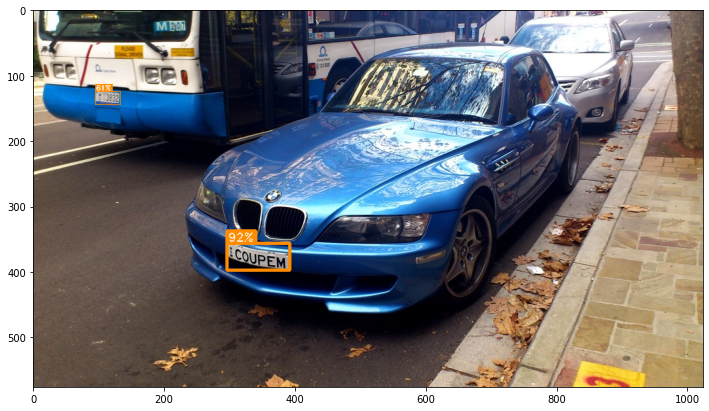

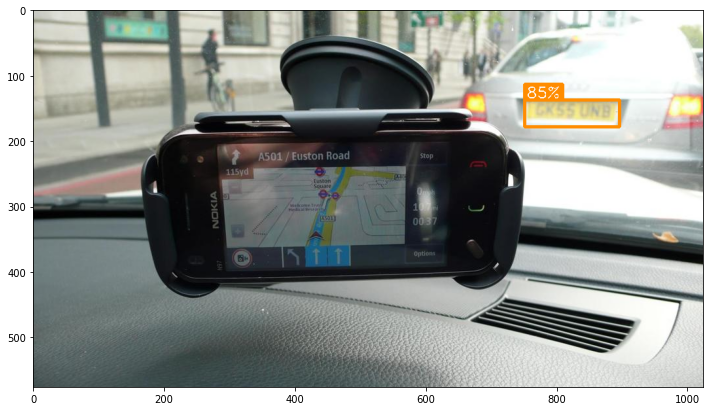

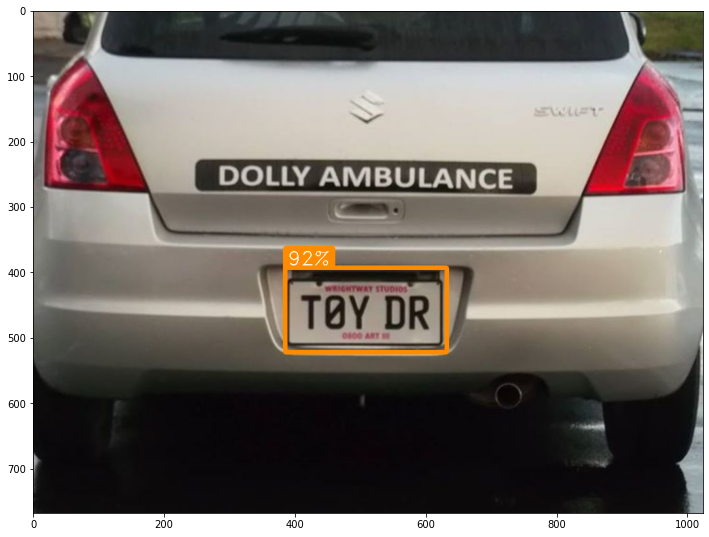

In [16]:
for i in range(3):
    Annotator.show_image(Annotator.annotate_infer_dict(infer_dict_list[i]))
    

#  <font style="color:green">4. COCO Detection Evaluation [25 Points]</font> 

**You have to evaluate your detection model on COCO detection evaluation metric.**

For your reference here is the coco evaluation metric chart:


---

<img src="https://www.learnopencv.com/wp-content/uploads/2020/03/c3-w9-coco_metric.png">

---

#### <font style="color:red">The expected `AP` (primary challenge metric) is more than `0.5`.</font>

**The expected output should look similar to the following:**

```
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.550
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.886
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.629
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.256
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.653
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.627
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.504
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.629
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.633
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.380
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.722
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.704
```



## <font style="color:orange">Detection Model Evaluation</font>

The following cell calls the inferencer's `evaluate_model()` method to evaluate the model with the highest mAP on the COCO detection evaluation metrics.

In [17]:
results_dict, results_text = inferencer.evaluate_model()

print("Results: %s\n" % ", ".join([f"{k}={v:.3f}" for k,v in results_dict.items()]))
print("Results - Human Readable Text")
print("------------------------------------------------------------------------------")
print('\n'.join(results_text))

Results: AP=62.458, AP50=87.180, AP75=74.980, APs=25.672, APm=71.679, APl=74.472

Results - Human Readable Text
------------------------------------------------------------------------------
Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.625
Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.872
Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.750
Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.257
Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.717
Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.745
Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.577
Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.705
Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.712
Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.428
Average Recall     

# <font style="color:green">5. Run Inference on a Video [15 Points]</font>

#### [Download the Input Video](https://www.dropbox.com/s/g88o4dx18zpgn8k/projet3-input-video.mp4?dl=1)

**You have to run inference on a video.** 

You can download the video from [here](https://www.dropbox.com/s/g88o4dx18zpgn8k/projet3-input-video.mp4?dl=1).

#### <font style="color:red">Upload the output video on youtube and share the link. Do not upload the video in the lab.</font>

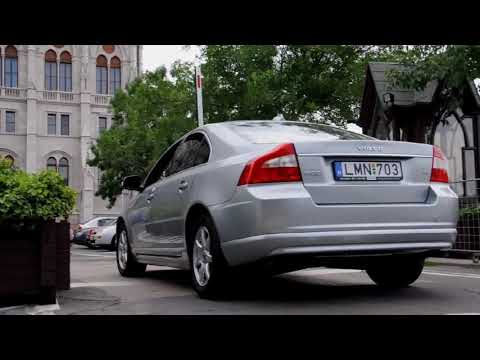

In [20]:
from IPython.display import YouTubeVideo, display
video = YouTubeVideo("18HWHCevFdU", width=640, height=360)
display(video)

**Your output video should have a bounding box around the vehicle registration plate.**

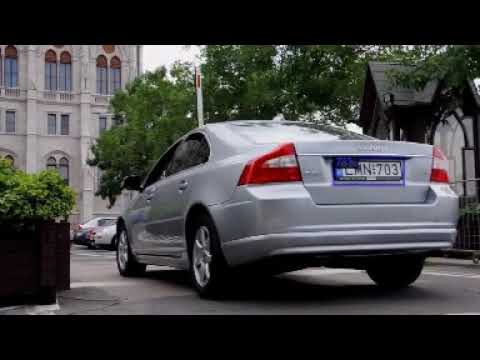

In [21]:
video = YouTubeVideo("5SgCuee7AMs", width=640, height=360)
display(video)

## <font style="color:orange">Detection and Annotating a Video</font>

I modified the sample function to read the source video frame-by-frame, detect and annotate license plates in each frame, and create an output video. I uploaded this video to YouTube and it may be viewed in this notebook's last cell. Again, Detectron2 provides this capability (see the [detectron2.utils.video_visualizer module](https://detectron2.readthedocs.io/en/latest/modules/utils.html#module-detectron2.utils.video_visualizer) documentation for more details).

In [26]:
def annotate_video(inferencer, src_video_path, dst_video_path, frames_dir=None, vis_thd=0.4):
    """
    Create a new video by annotating license plates in the source video.
    
    src_video_path (str): path of source video in which to annotate
    dst_video_path (str): path to destination video in which to create
    frames_dir optional(str): if specified, direction to write annotated frames
    """
    
    if frames_dir is not None:
        os.makedirs(frames_dir, exist_ok=True)
    
    # create a video reader
    reader = cv2.VideoCapture(src_video_path)
    if not reader.isOpened(): 
        print("Error opening video file")
        return
        
    # get source video attributes
    width = int(reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(reader.get(cv2.CAP_PROP_FRAME_HEIGHT))
    frames_per_second = float(reader.get(cv2.CAP_PROP_FPS))
    
    # create a video writer
    writer = cv2.VideoWriter(
        filename = dst_video_path,
        fourcc = cv2.VideoWriter_fourcc(*"mp4v"),
        fps =  frames_per_second,
        frameSize = (width, height),
        isColor=True,
    )
    
    # for each frame in the source video ...
    count = 0
    while reader.isOpened():
        # read the frame
        ret, frame = reader.read()
        if ret:
            # detect and annotate license plates
            frame_dict = inferencer.prepare_bgr_image(frame)
            infer_dict = inferencer.inference_prepared_bgr_image(frame_dict, thd=vis_thd)
            frame = Annotator.annotate_infer_dict(infer_dict, frame)
            
            # write frame to destination video
            writer.write(frame)
            
            # if specified, write frame to frames directory
            if frames_dir is not None:
                name = f"frame{count:04d}.jpg"
                path = os.path.join(frames_dir, name)
                cv2.imwrite(path, frame)
            count += 1
        else:
            break
    
    # free reader and writer resources
    reader.release()
    writer.release()
    
    return

In [29]:
frames_dir = os.path.join(Inferencer._output_dir, "VideoFrames")
annotate_video(inferencer, "project3-input-video.mp4", "project3-output-video-retinanet101-aug.mp4")

### <font style="color:orange">Annotated Video Using RetinaNet101 Model w/ Data Augmentation</font>

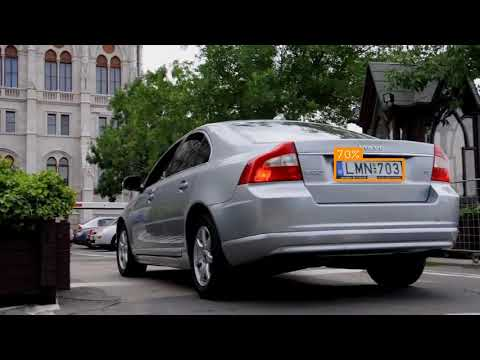

In [30]:
video = YouTubeVideo("oMURlILCDqo", width=640, height=360)
display(video)

### <font style="color:orange">Annotated Video Using Faster R-CNN X101 Model w/o Data Augmentation</font>

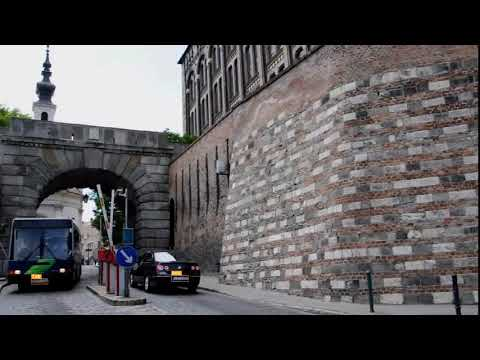

In [32]:
video = YouTubeVideo("741phKYWYVM", width=640, height=360)
display(video)